In [2]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import mplhep as hep

from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema
import awkward as ak

plt.style.use(hep.style.CMS)
plt.clf()
plt.close("all")

# ordered as [edgecolor, facecolor]
mainblue = ["#42719f", "#6ab4ff"]
coralgreen = ["#117a65", "#138D75"]
reddish = ["#c82929", "#e42f2f"]
orangish = ["#d78939", "#e48a2f"]
blueish = ["#4387cb", "#2f89e4"]

plt.rcParams["font.family"] = "Helvetica Neue"

In [3]:
def PxPyPzE(v): # need this to be able to add four-vectors
    pt  = v[:,0:1]
    eta = v[:,1:2]
    phi = v[:,2:3]
    m   = v[:,3:4]
    
    Px, Py, Pz = pt*phi.cos(), pt*phi.sin(), pt*eta.sinh()
    E = (pt**2 + Pz**2 + m**2).sqrt()

    return torch.cat( (Px,Py,Pz,E), 1 )


def PtEtaPhiM(v):
    px = v[:,0:1]
    py = v[:,1:2]
    pz = v[:,2:3]
    e  = v[:,3:4]

    Pt  = (px**2+py**2).sqrt()
    ysign = py.sign()
    ysign = ysign + (ysign==0.0).float() # if py==0, px==Pt and acos(1)=pi/2 so we need zero protection on py.sign()
    Phi = (px/Pt).acos() * ysign
    Eta = (pz/Pt).asinh()

    M = F.relu(e**2 - px**2 - py**2 - pz**2).sqrt()

    return torch.cat( (Pt, Eta, Phi, M) , 1 ) 
    

## Load friend TTrees of the 3-fold model

In [30]:
train_region = 'preselection'
NanoAODSchema.warn_missing_crossrefs = False
fourTag_true = NanoEventsFactory.from_root(f'../../data/fourTag_picoAOD.root', schemaclass = NanoAODSchema.v7, treepath = 'Events').events()
fourTag_rec = NanoEventsFactory.from_root(f'../../data/fourTag_dec.root', schemaclass = NanoAODSchema.v7, treepath = 'Events').events()

In [31]:
fourTag_rec.dec.fields

['nJet',
 'Jet1_pt',
 'Jet1_eta',
 'Jet1_phi',
 'Jet1_mass',
 'Jet2_pt',
 'Jet2_eta',
 'Jet2_phi',
 'Jet2_mass',
 'Jet3_pt',
 'Jet3_eta',
 'Jet3_phi',
 'Jet3_mass',
 'Jet4_pt',
 'Jet4_eta',
 'Jet4_phi',
 'Jet4_mass']

Flip $\eta$

In [32]:
signEta = 1-2*(fourTag_true.Jet.eta[:, 0]<0)
eta_rot_true = fourTag_true.Jet.eta * signEta # flip first eta

signEta = 1-2*(fourTag_rec.dec.Jet1_eta[:]<0)
eta1_rot_rec = fourTag_rec.dec.Jet1_eta * signEta # flip first eta
eta2_rot_rec = fourTag_rec.dec.Jet2_eta * signEta # flip second eta
eta3_rot_rec = fourTag_rec.dec.Jet3_eta * signEta # flip third eta
eta4_rot_rec = fourTag_rec.dec.Jet4_eta * signEta # flip fourth eta

## Jet $\eta$

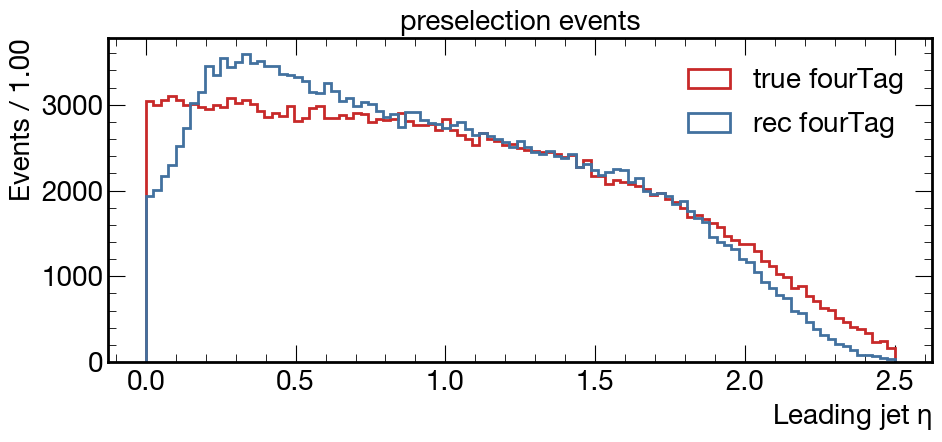

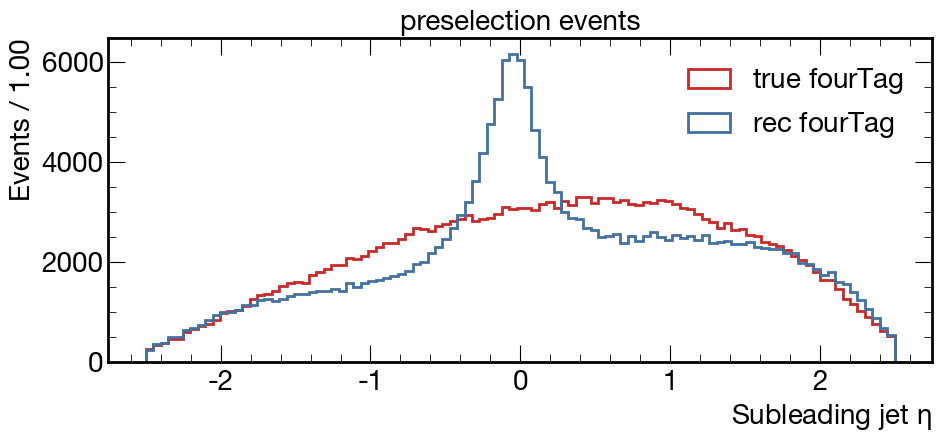

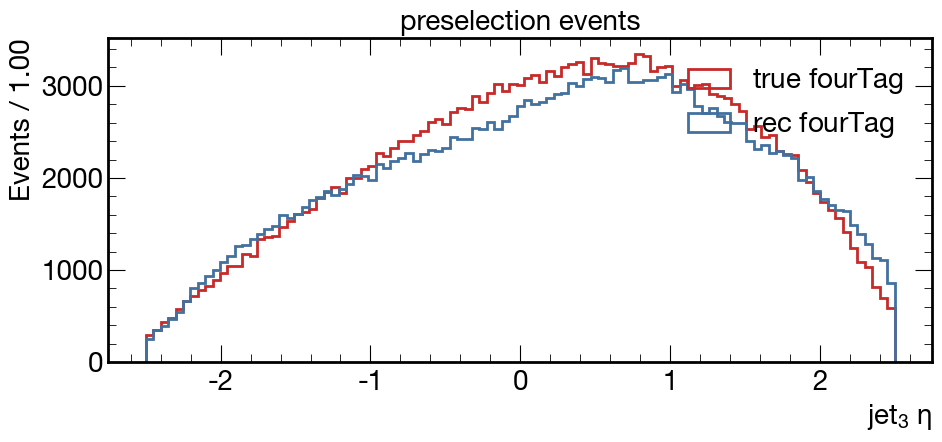

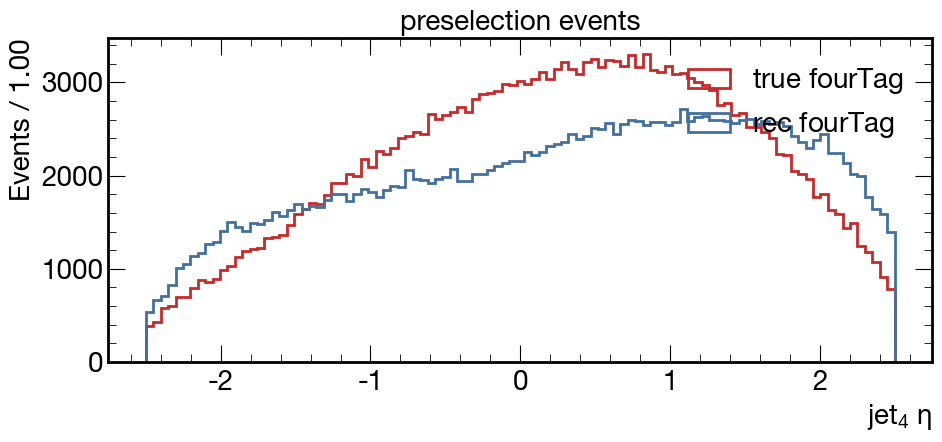

In [40]:
################################################################################################################################################################################################
# Leading jet eta #
################################################################################################################################################################################################
_min = 0.
_max = 100.
width = 1 # GeV
nbins = int(round((_max - _min) / width)) + 1


fig, ax = plt.subplots(figsize=(10, 5))

h1, bins1, _ = ax.hist(
    eta_rot_true[:, 0],
    bins = nbins,
    histtype = 'step',
    ec = reddish[0],
    facecolor = None,
    #alpha = .3,
    lw = 2.,
    label = r"$true\ fourTag$"
)
h2, bins2, _ = ax.hist(
    eta1_rot_rec,
    bins = bins1,
    histtype ='step',
    ec = mainblue[0],
    facecolor = None,
    #alpha = .9,
    lw = 2.,
    label = r"$rec\ fourTag$"
)

#ax.set_yscale("log")
#ax.set_xscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.set_xlabel(r"Leading jet $\eta$", fontsize = 20)
ax.set_ylabel("Events / %.2f" % width, fontsize = 20)
#ax.text((_max + _min) / 2 - .2 * (_max + _min) / 2, .70 * ak.max(h1), "Nevents $=$ %s" % len(HH4b.Jet_pt))
#ax.set_xlim(0, 2500)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 20)
ax.set_title("preselection events", fontsize = 20)
fig.tight_layout()
plt.savefig(f"plots/autoencoder/fourTag_dec_leadingJet_eta.pdf")



################################################################################################################################################################################################
# Subleading jet eta #
################################################################################################################################################################################################

_min = 0.
_max = 100.
width = 1 # GeV
nbins = int(round((_max - _min) / width)) + 1


fig, ax = plt.subplots(figsize=(10, 5))

h1, bins1, _ = ax.hist(
    eta_rot_true[:, 1],
    bins = nbins,
    histtype = 'step',
    ec = reddish[0],
    facecolor = None,
    #alpha = .3,
    lw = 2.,
    label = r"$true\ fourTag$"
)
h2, bins2, _ = ax.hist(
    eta2_rot_rec,
    bins = bins1,
    histtype ='step',
    ec = mainblue[0],
    facecolor = None,
    #alpha = .9,
    lw = 2.,
    label = r"$rec\ fourTag$"
)

#ax.set_yscale("log")
#ax.set_xscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.set_xlabel(r"Subleading jet $\eta$", fontsize = 20)
ax.set_ylabel("Events / %.2f" % width, fontsize = 20)
#ax.text((_max + _min) / 2 - .2 * (_max + _min) / 2, .70 * ak.max(h1), "Nevents $=$ %s" % len(HH4b.Jet_pt))
#ax.set_xlim(0, 2500)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 20)
ax.set_title("preselection events", fontsize = 20)
fig.tight_layout()
plt.savefig(f"plots/autoencoder/fourTag_dec_subleadingJet_eta.pdf")




################################################################################################################################################################################################
# Jet 3 eta #
################################################################################################################################################################################################

_min = 0.
_max = 100.
width = 1 # GeV
nbins = int(round((_max - _min) / width)) + 1


fig, ax = plt.subplots(figsize=(10, 5))

h1, bins1, _ = ax.hist(
    eta_rot_true[:, 2],
    bins = nbins,
    histtype = 'step',
    ec = reddish[0],
    facecolor = None,
    #alpha = .3,
    lw = 2.,
    label = r"$true\ fourTag$"
)
h2, bins2, _ = ax.hist(
    eta3_rot_rec,
    bins = bins1,
    histtype ='step',
    ec = mainblue[0],
    facecolor = None,
    #alpha = .9,
    lw = 2.,
    label = r"$rec\ fourTag$"
)

#ax.set_yscale("log")
#ax.set_xscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.set_xlabel(r"jet$_{3}$ $\eta$", fontsize = 20)
ax.set_ylabel("Events / %.2f" % width, fontsize = 20)
#ax.text((_max + _min) / 2 - .2 * (_max + _min) / 2, .70 * ak.max(h1), "Nevents $=$ %s" % len(HH4b.Jet_pt))
#ax.set_xlim(0, 2500)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 20)
ax.set_title("preselection events", fontsize = 20)
fig.tight_layout()
plt.savefig(f"plots/autoencoder/fourTag_dec_Jet3_eta.pdf")




################################################################################################################################################################################################
# Jet 4 eta #
################################################################################################################################################################################################

_min = 0.
_max = 100.
width = 1 # GeV
nbins = int(round((_max - _min) / width)) + 1


fig, ax = plt.subplots(figsize=(10, 5))

h1, bins1, _ = ax.hist(
    eta_rot_true[:, 3],
    bins = nbins,
    histtype = 'step',
    ec = reddish[0],
    facecolor = None,
    #alpha = .3,
    lw = 2.,
    label = r"$true\ fourTag$"
)
h2, bins2, _ = ax.hist(
    eta4_rot_rec,
    bins = bins1,
    histtype ='step',
    ec = mainblue[0],
    facecolor = None,
    #alpha = .9,
    lw = 2.,
    label = r"$rec\ fourTag$"
)

#ax.set_yscale("log")
#ax.set_xscale("log")
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.set_xlabel(r"jet$_{4}$ $\eta$", fontsize = 20)
ax.set_ylabel("Events / %.2f" % width, fontsize = 20)
#ax.text((_max + _min) / 2 - .2 * (_max + _min) / 2, .70 * ak.max(h1), "Nevents $=$ %s" % len(HH4b.Jet_pt))
#ax.set_xlim(0, 2500)
#ax.set_ylim(0, 5)
ax.legend(loc = "best", fontsize = 20)
ax.set_title("preselection events", fontsize = 20)
fig.tight_layout()
plt.savefig(f"plots/autoencoder/fourTag_dec_Jet4_eta.pdf")